In [31]:
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Parse SCM specification from JSON file
def parse_scm(input):
    data = json.loads(input)
    nodes = data['nodes']
    functions = data['functions']
    noise = data['noise']

    G = nx.DiGraph()
    G.add_nodes_from(data['nodes'])
    G.add_edges_from(data['edges'])

    return nodes, G, functions, noise

In [26]:
class SCM:    
    def __init__(self, input):
        self.nodes, self.G, self.F, self.N = parse_scm(input)
        self.interventions = {}

    def intervene(self, interventions):
        """Perform interventions on multiple variables.

        Interventions can be perfect (constant value) or soft (stochastic function).
        """
        for variable, func in interventions.items():
            self.interventions[variable] = func
    def sample(self, n_samples):
        """Generate random samples form the SCM"""
        data = {}

        # Initialize each node in the graph
        for X_j in self.G.nodes:
            data[X_j] = np.zeros(n_samples)

        # Apply interventions
        for X_j, f_j in self.interventions.items():
            # For soft interventions
            if callable(f_j):
                data[X_j] = f_j()
            # For perfect interventions
            else:
                data[X_j] = f_j

        # Generate samples in topological node order
        for X_j in nx.topological_sort(self.G):
            if X_j in self.interventions:
                continue
            # Generate noise
            noise = eval(self.N[X_j])
            # Propagate noise
            f_j = eval(self.F[X_j])
            pa_j = list(self.G.predecessors(X_j))
            parent_data = [data[parent] for parent in pa_j]
            # Additive noise
            data[X_j] = f_j(*parent_data) + noise

        return data

    def abduction(self, L1):
        """Infer the values of the exogenous variables given observational data"""
        noise_data = {}
        for X_j in self.G.nodes:
            f_j = eval(self.F[X_j])
            pa_j = list(self.G.predecessors(X_j))
            parents_data = [L1[parent] for parent in pa_j]
            inferred_noise = L1[X_j] - f_j(*parents_data)
            noise_data[X_j] = inferred_noise
        return noise_data

    def counterfactual(self, L1, intervetions, n_samples):
        """Compute counterfactual distribution given L1-data and an intervention."""
        # Step 1: Abduction - Update the noise distribution given the observations
        noise_data = self.abduction(L1)

        # Step 2: Action - Intervene within the observationally constrained SCM
        self.intervene(intervetions)
        L2 = self.sample(n_samples)

        # Step 3: Prediction - Generate samples in the modified model
        L3 = {node: np.zeros(n_samples) for node in self.G.nodes}
        for X_j in nx.topological_sort(self.G):
            if X_j in L2:
                L3[X_j] = L2[X_j]
                continue

            N_j = noise_data[X_j]
            f_j = eval(self.F[X_j])
            pa_j = list(self.G.predecessors(X_j))
            parents_data = [L3[parent] for parent in pa_j]
            L3[X_j] = f_j(*parents_data) + noise_data

        return L3

    def visualize(self):
        pos = nx.spring_layout(self.G)
        nx.draw(self.G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=10, font_weight='bold')
        
    def plot_distributions(self, data):
        """Plot the distributions of the nodes based on the sampled data."""
        num_nodes = len(data)
        fig, axes = plt.subplots(num_nodes, 1, figsize=(10, 5 * num_nodes))
        
        if num_nodes == 1:
            axes = [axes]

        for i, node in enumerate(data):
            axes[i].hist(data[node], bins=30, density=True, alpha=0.7, color='blue')
            axes[i].set_title(f'Distribution of {node}')
            axes[i].set_xlabel(node)
            axes[i].set_ylabel('Density')
        
        plt.tight_layout()
        plt.show()

{'X1': 5, 'X2': array([1.08689458, 1.91948248, 2.92054048, 1.79185301, 2.13190547,
       2.63671995, 2.22847015, 2.69877805, 1.13676514, 1.95974668,
       2.14766434, 2.08704794, 2.09631616, 0.93228351, 1.93852756,
       2.04134162, 2.18341678, 2.29915086, 1.72936139, 0.97553036,
       1.71493438, 3.4411913 , 1.25388393, 2.28160593, 1.97000696,
       1.84922798, 2.44836564, 1.53074967, 1.11425251, 0.92625479,
       1.78969615, 1.96293538, 1.41269214, 2.67678269, 3.12145899,
       1.79205911, 2.31252199, 1.90435561, 2.77726536, 1.94372407,
       2.02327906, 0.9913218 , 2.13141818, 1.64702138, 2.07383127,
       2.78983212, 1.32171983, 2.64480343, 1.17184557, 2.63159322,
       2.27384509, 1.20123758, 0.70004923, 1.98173421, 2.0792561 ,
       1.89468587, 2.36379163, 1.71615537, 1.82670693, 1.75620224,
       2.38806261, 1.44288248, 2.89955521, 2.43557419, 1.83578957,
       1.8298627 , 2.2049647 , 1.57816797, 2.46636268, 2.16080479,
       2.63123955, 2.02577171, 1.28577238, 2.3

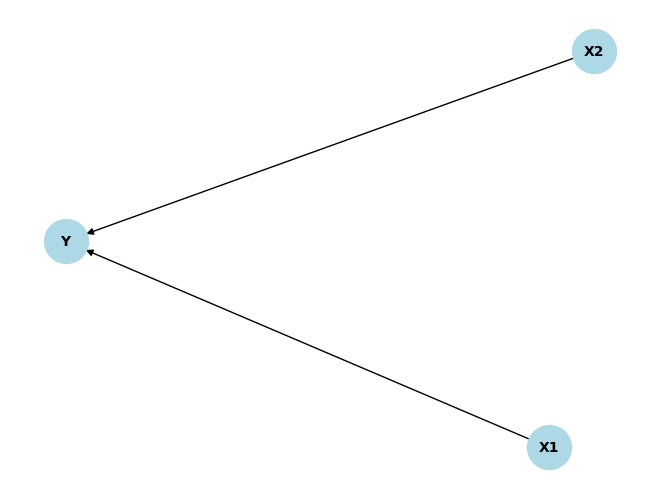

In [27]:
input = '''
{
    "nodes": ["X1", "X2", "Y"],
    "edges": [["X1", "Y"], ["X2", "Y"]],
    "functions": {
        "X1": "lambda: np.random.normal(0, 1, n_samples)",  
        "X2": "lambda: np.random.normal(0, 1, n_samples)",
        "Y": "lambda x1, x2: 2*x1 + 3*x2"
    },
    "noise": {
        "X1": "np.random.normal(0, 1)",
        "X2": "np.random.normal(0, 1)",
        "Y": "np.random.normal(0, 1)"
    }
}
'''  


scm = SCM(input)

# Visualize the SCM
scm.visualize()

# Generate data
n_samples = 1000
data = scm.sample(n_samples)

# Observed data for abduction (taking the first sample)
observed_data = {node: data[node][0] for node in nodes}

# Define interventions
interventions = {
    "X1": 5,  # Perfect intervention
    "X2": lambda: np.random.normal(2, 0.5, n_samples)  # Soft intervention
}

# Compute counterfactual distribution
L3 = scm.counterfactual(observed_data, interventions, n_samples)

print(L3)

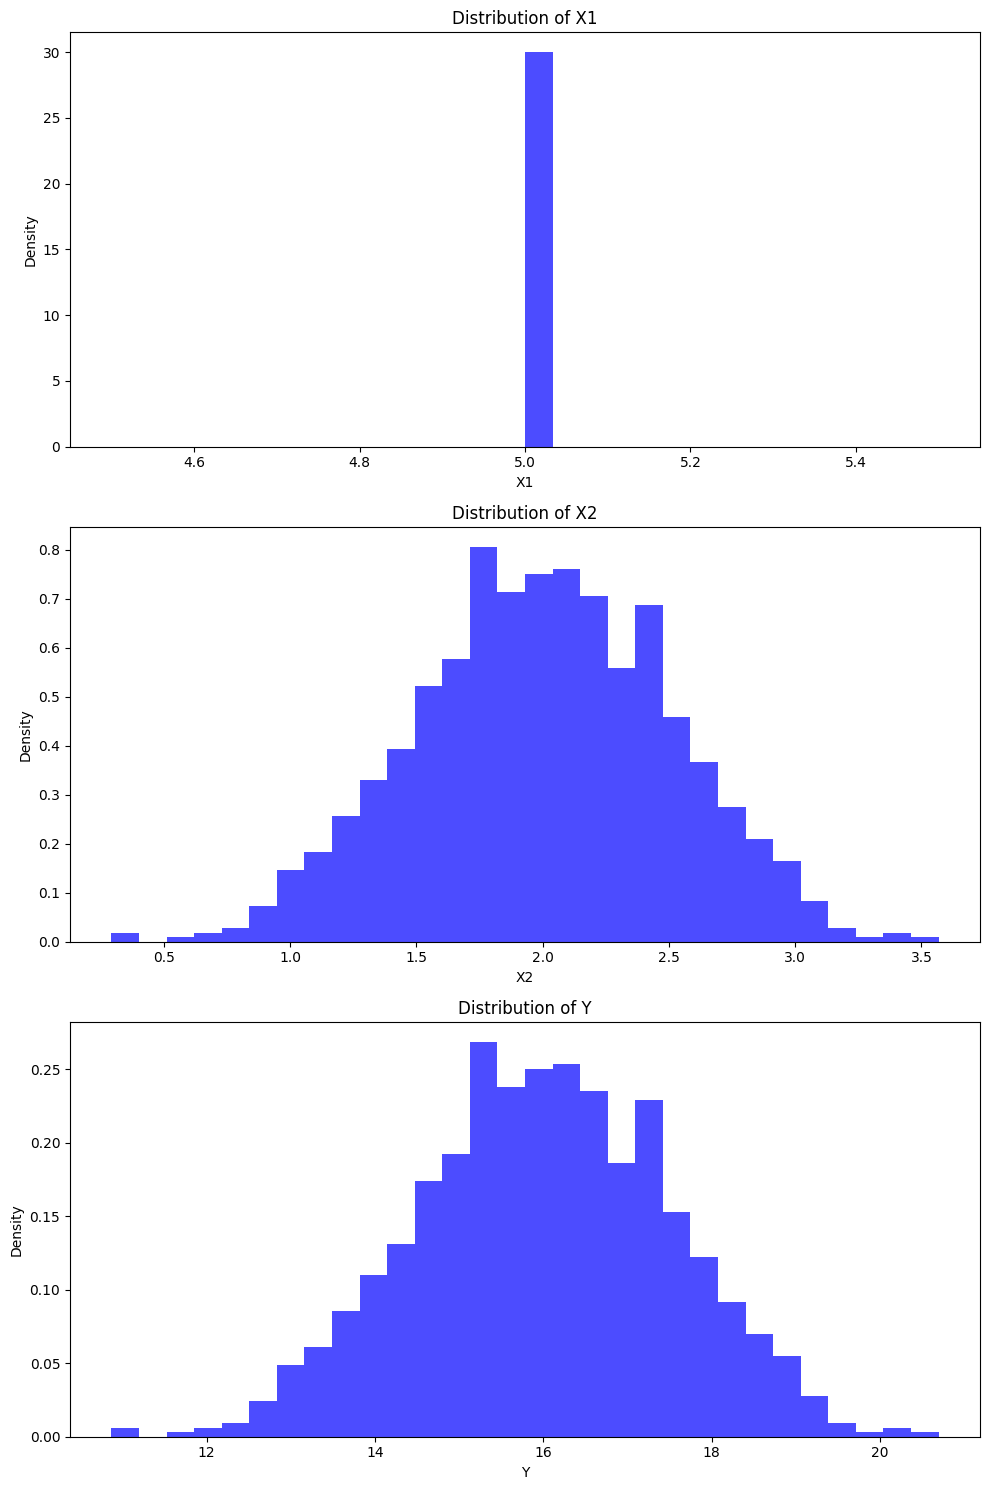

In [32]:
scm.plot_distributions(L3)